In [9]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('seg3.csv')

--- ĐANG XÂY DỰNG BINNING CHO: 3. Mass Unsecured ---
Số lượng mẫu: 283,403
Bad Rate: 27.50%

Processing: N_AVG_DEPOSIT_12M...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 317679.00)",14265,0.050335,7130,7135,0.500175,-0.970063,0.055144,6.634789e-03
1,"[317679.00, 485679.00)",16753,0.059114,9553,7200,0.429774,-0.686588,0.031505,3.862573e-03
2,"[485679.00, 666811.50)",20936,0.073874,12835,8101,0.386941,-0.509174,0.021117,2.611504e-03
3,"[666811.50, 854972.00)",22353,0.078874,14454,7899,0.353375,-0.365127,0.011320,1.407153e-03
4,"[854972.00, 977113.00)",14281,0.050391,9595,4686,0.328128,-0.252699,0.003393,4.229603e-04
5,"[977113.00, 1101919.00)",14582,0.051453,10103,4479,0.307160,-0.155929,0.001294,1.615618e-04
6,"[1101919.00, 1228897.00)",14364,0.050684,10113,4251,0.295948,-0.102695,0.000547,6.830416e-05
7,"[1228897.00, 1421285.00)",20484,0.072279,14877,5607,0.273726,0.006439,0.000003,3.739907e-07
8,"[1421285.00, 1708481.50)",28240,0.099646,21210,7030,0.248938,0.134924,0.001758,2.195801e-04
9,"[1708481.50, 1890214.50)",16311,0.057554,12631,3680,0.225615,0.263879,0.003762,4.689448e-04


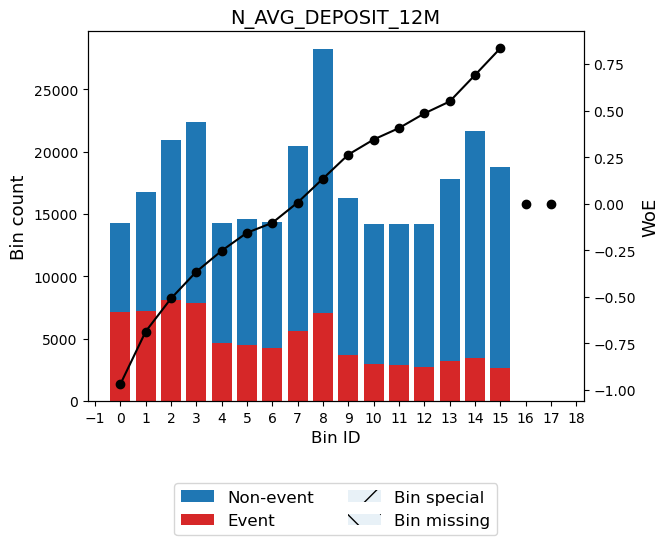


Processing: LTV...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",283403,1.0,205465,77938,0.275008,-0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,283403,1.0,205465,77938,0.275008,,0.0,0.0


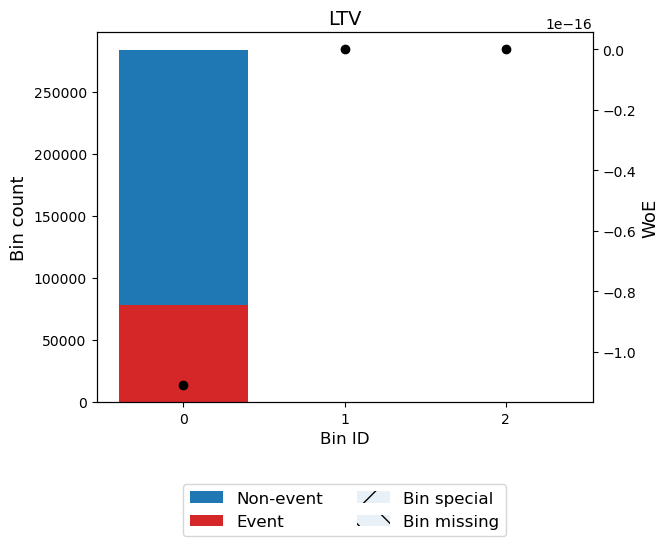


Processing: INCOME...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 13127978.00)",14196,0.050091,9810,4386,0.308960,-0.164377,0.001402,0.000175
1,"[13127978.00, 15940395.00)",37496,0.132306,26676,10820,0.288564,-0.066994,0.000603,0.000075
2,"[15940395.00, 16988989.00)",18997,0.067032,13609,5388,0.283624,-0.042805,0.000124,0.000015
3,"[16988989.00, 18823286.00)",33155,0.116989,23791,9364,0.282431,-0.036927,0.000161,0.000020
4,"[18823286.00, 20060166.00)",21817,0.076982,15762,6055,0.277536,-0.012644,0.000012,0.000002
5,"[20060166.00, 20864450.00)",16401,0.057872,11945,4456,0.271691,0.016699,0.000016,0.000002
6,"[20864450.00, 25664428.00)",75804,0.267478,55280,20524,0.270751,0.021454,0.000123,0.000015
7,"[25664428.00, 38757524.00)",48573,0.171392,36009,12564,0.258662,0.083571,0.001174,0.000147
8,"[38757524.00, inf)",16964,0.059858,12583,4381,0.258253,0.085708,0.000431,0.000054
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


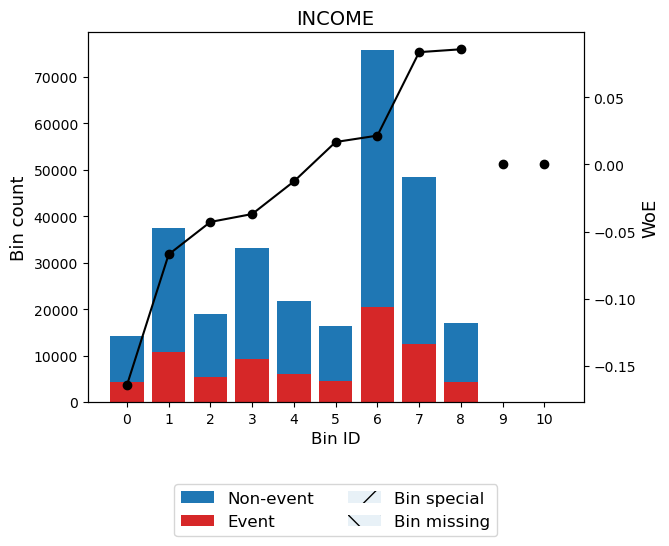


Processing: CBAL_TO_INC_12MON...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.29)",16473,0.058126,13628,2845,0.172707,0.597201,1.781107e-02,2.193877e-03
1,"[5.29, 8.00)",38441,0.135641,30859,7582,0.197237,0.434289,2.297763e-02,2.849843e-03
2,"[8.00, 8.86)",14185,0.050052,10276,3909,0.275573,-0.002833,4.018494e-07,5.023116e-08
3,"[8.86, 11.59)",45201,0.159494,32442,12759,0.282273,-0.036145,2.100588e-04,2.625592e-05
4,"[11.59, 12.76)",18425,0.065013,13224,5201,0.282280,-0.03618,8.578926e-05,1.072307e-05
5,"[12.76, 14.82)",30210,0.106597,21507,8703,0.288083,-0.064651,4.519728e-04,5.648676e-05
6,"[14.82, 17.59)",34462,0.121601,24320,10142,0.294295,-0.094748,1.114563e-03,1.392683e-04
7,"[17.59, 20.26)",26584,0.093803,18604,7980,0.300181,-0.122924,1.455817e-03,1.818627e-04
8,"[20.26, 23.86)",24996,0.088199,17220,7776,0.311090,-0.174333,2.782648e-03,3.473913e-04
9,"[23.86, 28.42)",18592,0.065603,12725,5867,0.315566,-0.195137,2.604121e-03,3.249996e-04


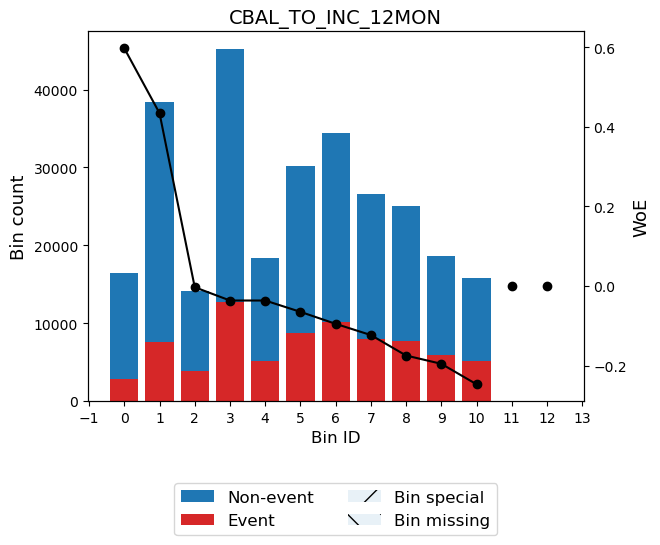


Processing: RATE_AVG...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.59)",26408,0.093182,21393,5015,0.189905,0.481268,0.019142,0.002370
1,"[5.59, 6.21)",17774,0.062716,13897,3877,0.218128,0.307249,0.005497,0.000684
2,"[6.21, 6.64)",15421,0.054414,11872,3549,0.230141,0.238155,0.002916,0.000364
3,"[6.64, 6.97)",14287,0.050412,10808,3479,0.243508,0.16418,0.001308,0.000163
4,"[6.97, 7.35)",17931,0.063270,13406,4525,0.252356,0.116723,0.000839,0.000105
5,"[7.35, 7.90)",28287,0.099812,20894,7393,0.261357,0.069566,0.000475,0.000059
6,"[7.90, 8.64)",39679,0.140009,28892,10787,0.271857,0.015861,0.000035,0.000004
7,"[8.64, 9.20)",27967,0.098683,19890,8077,0.288805,-0.068165,0.000465,0.000058
8,"[9.20, 9.65)",20745,0.073200,14526,6219,0.299783,-0.121031,0.001101,0.000138
9,"[9.65, 10.36)",26730,0.094318,18324,8406,0.314478,-0.190096,0.003549,0.000443


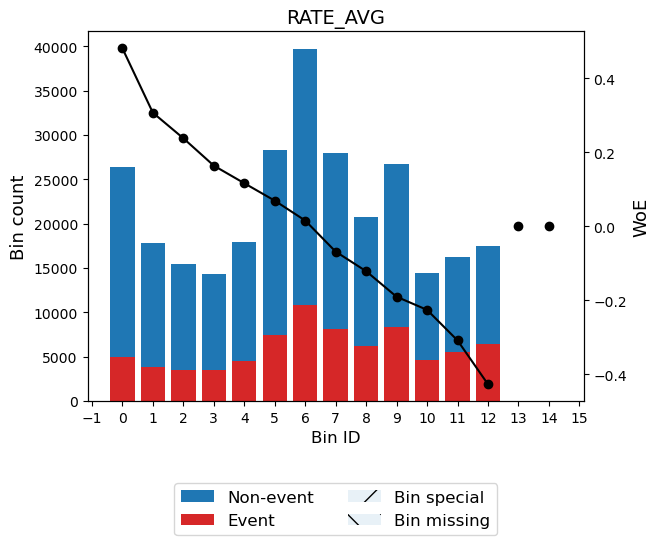


Processing: MAX_DPD_12M_OBS...


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 3.50)",27391,0.096650,27191,200,0.007302,3.942962,0.511689,0.040400
1,"[3.50, 6.50)",17989,0.063475,17788,201,0.011173,3.513612,0.295127,0.025059
2,"[6.50, 9.50)",16875,0.059544,16654,221,0.013096,3.352881,0.262261,0.022878
3,"[9.50, 13.50)",20577,0.072607,19320,1257,0.061088,1.763051,0.137346,0.015241
4,"[13.50, 17.50)",18467,0.065162,16963,1504,0.081443,1.453544,0.091954,0.010578
5,"[17.50, 22.50)",20466,0.072215,18257,2209,0.107935,1.142647,0.069146,0.008202
6,"[22.50, 26.50)",15188,0.053592,13126,2062,0.135765,0.881557,0.032994,0.003996
7,"[26.50, 35.50)",30230,0.106668,24210,6020,0.199140,0.422316,0.017142,0.002127
8,"[35.50, 45.50)",28661,0.101132,19860,8801,0.307072,-0.15552,0.002529,0.000316
9,"[45.50, 54.50)",21940,0.077416,12561,9379,0.427484,-0.677238,0.040096,0.004918


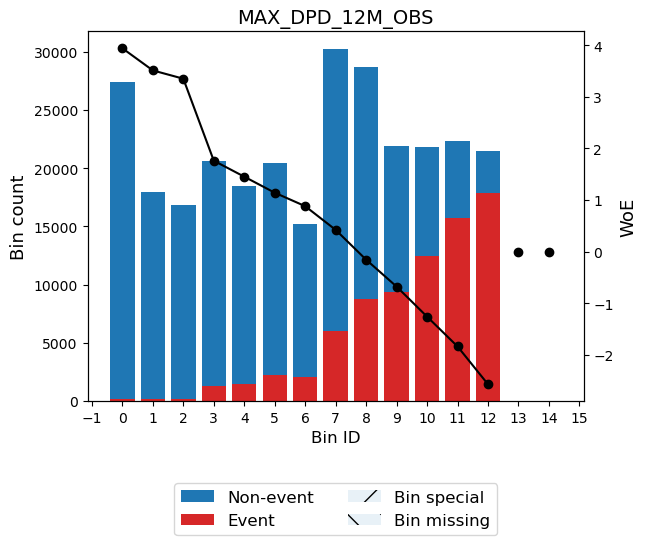

In [11]:
# ==========================================
# 14. WOE BINNING CHO PHÂN KHÚC "MASS UNSECURED"
# ==========================================
from optbinning import OptimalBinning
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu cho phân khúc Mass
target_segment = '3. Mass Unsecured'
df_model = df[
    (df['SEGMENT'] == target_segment) & 
    (df['SAMPLE_TYPE'] == 'TRAIN')  # <--- THÊM DÒNG NÀY
].copy()

X_model = df_model.drop(columns=['BAD_NEXT_12M', 'SEGMENT', 'SAMPLE_TYPE', 'SOCIF', 'year'])
y_model = df_model['BAD_NEXT_12M']

print(f"--- ĐANG XÂY DỰNG BINNING CHO: {target_segment} ---")
print(f"Số lượng mẫu: {len(df_model):,}")
print(f"Bad Rate: {y_model.mean():.2%}")

# 2. Chọn danh sách biến cần Binning (Lấy Top IV từ bước trước)
# Ta bỏ MAX_DPD ra để xử lý riêng (vì nó quá mạnh), tập trung vào các biến tài chính/hành vi khác
selected_features = [
    'N_AVG_DEPOSIT_12M', 'LTV', 'INCOME', 
    'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS'
]

binning_results = {}

# 3. Chạy vòng lặp Binning và Vẽ hình
for feature in selected_features:
    print(f"\nProcessing: {feature}...")
    
    # Cấu hình Binning
    # monotonic_trend='auto_asc_desc': Tự động tìm xu hướng tăng/giảm đơn điệu
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip", 
                          monotonic_trend="auto_asc_desc",
                          min_prebin_size=0.05) # Mỗi bin tối thiểu 5% dân số
    
    optb.fit(X_model[feature], y_model)
    
    # Lưu kết quả
    binning_results[feature] = optb
    
    # Hiển thị bảng WOE
    bin_table = optb.binning_table.build()
    display(bin_table.head(10))
    
    # Vẽ biểu đồ WOE (Rất quan trọng để check logic)
    #  -> Code dưới sẽ vẽ ra hình tương tự
    optb.binning_table.plot(metric="woe")


=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===
Transforming: N_AVG_DEPOSIT_12M...
Transforming: LTV...
Transforming: INCOME...
Transforming: CBAL_TO_INC_12MON...
Transforming: RATE_AVG...
Transforming: MAX_DPD_12M_OBS...
------------------------------
Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):


,N_AVG_DEPOSIT_12M,LTV,INCOME,CBAL_TO_INC_12MON,RATE_AVG,MAX_DPD_12M_OBS,BAD_NEXT_12M
0,-0.252699,0.0,-0.066994,-0.036180,0.307249,1.763051,0
1,-0.365127,0.0,-0.066994,-0.122924,-0.225498,0.422316,0
2,0.835074,0.0,-0.036927,0.434289,0.015861,0.422316,0
3,0.344884,0.0,-0.066994,-0.036145,-0.121031,-0.155520,1
4,0.344884,0.0,0.021454,-0.246510,-0.121031,-0.155520,0



=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===


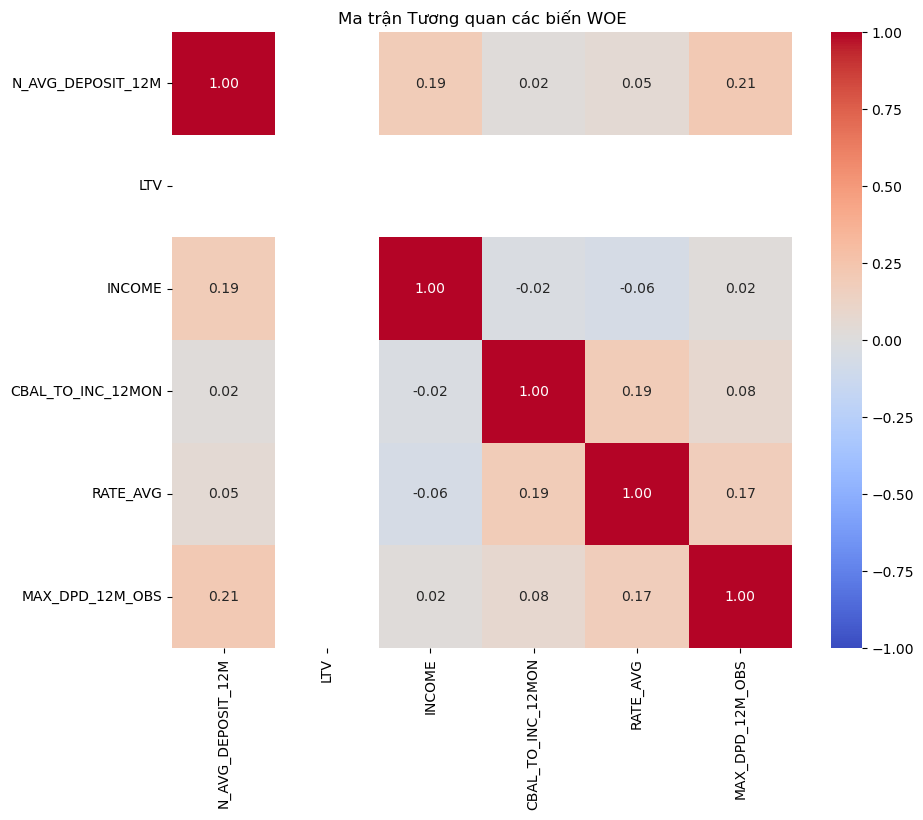

In [12]:
# ==========================================
# 15. TRANSFORMATION: CHUYỂN ĐỔI DỮ LIỆU SANG WOE
# ==========================================
print("\n=== CHUYỂN ĐỔI DỮ LIỆU GỐC SANG DẠNG WOE ===")

# Danh sách các biến đã chốt (Selected Features) cho mô hình Mass Unsecured
# (Đây là ví dụ, bạn có thể thêm bớt tùy vào kết quả IV/Binning của bước trước)
final_features = [
    'N_AVG_DEPOSIT_12M', 
    'LTV', 
    'INCOME', 
    'CBAL_TO_INC_12MON', 
    'RATE_AVG', 
    'MAX_DPD_12M_OBS'
]

# Tạo DataFrame mới để chứa giá trị WOE
X_woe = pd.DataFrame()
woe_models = {} # Lưu lại model binning để sau này dùng cho tập Test/OOT

for feature in final_features:
    print(f"Transforming: {feature}...")
    
    # Cấu hình Binning (dùng solver="mip" để tránh lỗi)
    optb = OptimalBinning(name=feature, dtype="numerical", solver="mip",
                          monotonic_trend="auto_asc_desc")
    
    # Fit và Transform
    optb.fit(X_model[feature], y_model)
    
    # Lưu giá trị WOE vào DataFrame mới
    X_woe[feature] = optb.transform(X_model[feature], metric="woe")
    
    # Lưu model lại
    woe_models[feature] = optb

# Thêm cột Target vào để tiện xử lý
X_woe['BAD_NEXT_12M'] = y_model.values

print("-" * 30)
print("Dữ liệu sau khi chuyển đổi WOE (5 dòng đầu):")
display(X_woe.head())

# ==========================================
# 16. KIỂM TRA TƯƠNG QUAN (MULTICOLLINEARITY)
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

print("\n=== KIỂM TRA ĐA CỘNG TUYẾN (CORRELATION MATRIX) ===")
# Mô hình Logistic Regression rất ghét các biến giống nhau (Tương quan cao)
# Nếu 2 biến có corr > 0.7, ta phải bỏ 1 biến.

corr = X_woe.drop(columns=['BAD_NEXT_12M']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Ma trận Tương quan các biến WOE")
plt.show()

In [13]:
# ==========================================
# 17. HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) - ĐÃ FIX LỖI INDEX
# ==========================================
import statsmodels.api as sm

print("\n=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===")

# 1. Loại bỏ LTV (Do bị hằng số trong phân khúc Mass Unsecured)
# Lưu ý: Kiểm tra kỹ tên cột trong X_woe xem có LTV không, nếu code trước đã drop hoặc chưa tạo thì lệnh này vẫn chạy ổn.
final_features_clean = [col for col in final_features if col != 'LTV']

print(f"Danh sách biến cuối cùng ({len(final_features_clean)} biến): {final_features_clean}")

# 2. Chuẩn bị dữ liệu & SỬA LỖI INDEX
# Reset index drop=True để cả X và y đều có index là 0, 1, 2, 3... khớp nhau 100%
X_train = X_woe[final_features_clean].reset_index(drop=True)
y_train = y_model.reset_index(drop=True)

# Thêm cột hằng số (Intercept/Bias)
X_train_const = sm.add_constant(X_train)

# 3. Fit mô hình Logistic Regression
try:
    logit_model = sm.Logit(y_train, X_train_const)
    result = logit_model.fit()
    
    # 4. Xuất báo cáo thống kê
    print(result.summary())
    
except Exception as e:
    print(f"Vẫn còn lỗi: {str(e)}")

# ==========================================
# 18. KIỂM TRA P-VALUE (SIGNIFICANCE)
# ==========================================
if 'result' in locals():
    print("\n--- ĐÁNH GIÁ CÁC BIẾN (P-VALUE CHECK) ---")
    p_values = result.pvalues
    
    # Lọc các biến có P-value cao (không có ý nghĩa thống kê)
    # Thường ngưỡng là 0.05
    high_p_value_vars = p_values[p_values >= 0.05]
    
    if len(high_p_value_vars) > 0:
        print("\nCẢNH BÁO: Các biến sau có P-value cao (cần xem xét loại bỏ):")
        print(high_p_value_vars)
    else:
        print("\nTUYỆT VỜI: Tất cả các biến đều có ý nghĩa thống kê (P < 0.05)!")


=== HUẤN LUYỆN MÔ HÌNH (LOGISTIC REGRESSION) ===
Danh sách biến cuối cùng (5 biến): ['N_AVG_DEPOSIT_12M', 'INCOME', 'CBAL_TO_INC_12MON', 'RATE_AVG', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.386879
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               283403
Model:                          Logit   Df Residuals:                   283397
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3422
Time:                        15:22:51   Log-Likelihood:            -1.0964e+05
converged:                       True   LL-Null:                   -1.6669e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-----------

In [14]:
# ==========================================
# 19. CHẠY LẠI MÔ HÌNH (FINAL MODEL) & ĐÁNH GIÁ GINI
# ==========================================
from sklearn.metrics import roc_auc_score

print("\n=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===")

# 1. Chốt danh sách biến cuối cùng (Chỉ giữ lại biến P < 0.05)
# Bỏ 'INCOME' và 'RATE_AVG' và 'LTV'
final_vars_v2 = ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS']

print(f"Biến đưa vào mô hình: {final_vars_v2}")

# 2. Chuẩn bị dữ liệu (Reset index để tránh lỗi)
X_train_v2 = X_woe[final_vars_v2].reset_index(drop=True)
y_train_v2 = y_model.reset_index(drop=True)

X_train_const_v2 = sm.add_constant(X_train_v2)

# 3. Fit mô hình
logit_final = sm.Logit(y_train_v2, X_train_const_v2)
result_final = logit_final.fit()

print(result_final.summary())

# ==========================================
# 20. TÍNH GINI & KẾT LUẬN SỨC MẠNH MÔ HÌNH
# ==========================================
print("\n--- ĐÁNH GIÁ SỨC MẠNH MÔ HÌNH (PERFORMANCE) ---")

# Dự báo xác suất (Probability) trên tập Train
y_pred_prob = result_final.predict(X_train_const_v2)

# Tính AUC
auc = roc_auc_score(y_train_v2, y_pred_prob)

# Tính Gini (Công thức: Gini = 2*AUC - 1)
gini = 2 * auc - 1

print(f"-> AUC Score: {auc:.4f}")
print(f"-> GINI Coefficient: {gini:.4f}")

if gini > 0.4:
    print("=> ĐÁNH GIÁ: Mô hình TUYỆT VỜI (Excellent).")
elif gini > 0.3:
    print("=> ĐÁNH GIÁ: Mô hình TỐT (Good).")
else:
    print("=> ĐÁNH GIÁ: Mô hình TRUNG BÌNH/YẾU.")


=== HUẤN LUYỆN MÔ HÌNH LẦN 2 (SAU KHI LOẠI BIẾN YẾU) ===
Biến đưa vào mô hình: ['N_AVG_DEPOSIT_12M', 'CBAL_TO_INC_12MON', 'MAX_DPD_12M_OBS']
Optimization terminated successfully.
         Current function value: 0.386883
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           BAD_NEXT_12M   No. Observations:               283403
Model:                          Logit   Df Residuals:                   283399
Method:                           MLE   Df Model:                            3
Date:                Mon, 05 Jan 2026   Pseudo R-squ.:                  0.3422
Time:                        15:22:53   Log-Likelihood:            -1.0964e+05
converged:                       True   LL-Null:                   -1.6669e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [15]:
# ==========================================
# 21. ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP OOS VÀ OOT (VALIDATION)
# ==========================================
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

print("\n=== KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN (TRAIN - OOS - OOT) ===")

# Danh sách các tập dữ liệu cần đánh giá
datasets = ['TRAIN', 'OOS', 'OOT']
metrics_summary = []

for sample_type in datasets:
    # 1. Lọc dữ liệu theo đúng Sample Type
    df_val = df[
        (df['SEGMENT'] == target_segment) & 
        (df['SAMPLE_TYPE'] == sample_type)
    ].copy()
    
    if len(df_val) == 0:
        print(f"⚠️ Không có dữ liệu cho tập {sample_type}")
        continue

    # 2. Chuyển đổi WOE (Dùng lại model đã học từ tập Train)
    # Lưu ý: woe_models đã được lưu ở Bước 15
    X_val_woe = pd.DataFrame()
    
    for feature in final_vars_v2:
        # Lấy "luật" binning đã học từ trước
        if feature in woe_models:
            binning_model = woe_models[feature]
            # Chỉ Transform, KHÔNG Fit lại
            X_val_woe[feature] = binning_model.transform(df_val[feature], metric="woe")
        else:
            print(f"❌ Lỗi: Không tìm thấy model binning cho biến {feature}")

    # 3. Chuẩn bị dữ liệu chạy mô hình
    # Reset index để tránh lệch dòng
    y_val = df_val['BAD_NEXT_12M'].reset_index(drop=True)
    X_val = X_val_woe.reset_index(drop=True)
    
    # Thêm hằng số (Intercept) giống hệt lúc Train
    X_val_const = sm.add_constant(X_val)

    # 4. Dự báo (Predict)
    # Dùng result_final đã train xong để chấm điểm
    y_pred_prob = result_final.predict(X_val_const)

    # 5. Tính Gini
    auc = roc_auc_score(y_val, y_pred_prob)
    gini = 2 * auc - 1
    
    # Lưu kết quả
    metrics_summary.append({
        'Sample': sample_type,
        'Observations': len(df_val),
        'Bad Rate': y_val.mean(),
        'AUC': auc,
        'GINI': gini
    })

# ==========================================
# 22. HIỂN THỊ BẢNG SO SÁNH
# ==========================================
results_df = pd.DataFrame(metrics_summary)
# Định dạng hiển thị % cho đẹp
results_df['Bad Rate'] = results_df['Bad Rate'].map('{:.2%}'.format)
results_df['AUC'] = results_df['AUC'].map('{:.2%}'.format)
results_df['GINI'] = results_df['GINI'].map('{:.2%}'.format)

print("-" * 60)
print(results_df)
print("-" * 60)

# Đánh giá độ ổn định
gini_train = float(results_df[results_df['Sample']=='TRAIN']['GINI'].values[0].strip('%')) / 100
gini_oot = float(results_df[results_df['Sample']=='OOT']['GINI'].values[0].strip('%')) / 100

diff = gini_train - gini_oot

print(f"\nĐỘ CHÊNH LỆCH (TRAIN - OOT): {diff:.2%}")
if abs(diff) > 0.20:
    print("=> CẢNH BÁO: MÔ HÌNH KHÔNG ỔN ĐỊNH (Chênh lệch Train/OOT quá lớn).")

# 2. Trường hợp Train cao hơn OOT nhiều -> Overfitting (Học vẹt)
elif diff > 0.10:
    print("=> CẢNH BÁO: MÔ HÌNH CÓ DẤU HIỆU OVERFITTING.")

# 3. Trường hợp OOT cao hơn Train một chút (Số âm nhỏ) -> Tốt (Reverse Vintage)
elif diff < 0:
    print("=> TỐT: Hiệu suất trên tập OOT còn tốt hơn tập Train (Reverse Vintage).")

# 4. Trường hợp còn lại (Chênh lệch dương nhỏ < 10%) -> Ổn định
else:
    print("=> MÔ HÌNH RẤT ỔN ĐỊNH (Stable).")


=== KẾT QUẢ ĐÁNH GIÁ TOÀN DIỆN (TRAIN - OOS - OOT) ===
------------------------------------------------------------
  Sample  Observations Bad Rate     AUC    GINI
0  TRAIN        283403   27.50%  87.37%  74.74%
1    OOS         77309   25.92%  87.66%  75.33%
2    OOT         76204   25.49%  87.85%  75.70%
------------------------------------------------------------

ĐỘ CHÊNH LỆCH (TRAIN - OOT): -0.96%
=> TỐT: Hiệu suất trên tập OOT còn tốt hơn tập Train (Reverse Vintage).
